In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import count
import pickle
import sys
sys.path.append('../..')
import brian_utils.postproc as bup
from brian2 import *

### Panel A

In [2]:
path = '/research/harris/prebot_opioid_model'

In [3]:
def plot_pop_rate(rate, gleak_target):
    ctrl_t = (30*second, 60*second)
    damgo_t = (70*second, 100*second)

    binsize = 25 * ms
    smoothed_pop_rate = bup.smooth_saved_rate(rate, binsize)
    burst_stats = bup.pop_burst_stats(rate['t'], smoothed_pop_rate, height = 4, prominence = 10)
    fig, ax = plt.subplots(2,2, figsize=(10,10))
    
    i = 0
    for t in [ctrl_t, damgo_t]:
        rate_idxs = np.where((rate['t'] >= t[0]) & (rate['t'] < t[1]))[0]
        ax[0,i].set_xlim(t)
        ax[0,i].set_xticks([])
        ax[0,i].set_ylim(0,40)
        ax[0,i].set_yticks(np.arange(0,41,10))
        ax[0,i].plot(rate['t'][rate_idxs], smoothed_pop_rate[rate_idxs], 'k', linewidth=1, alpha=0.5)
        ax[0,i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c = "tab:gray")
        ax[0,i].set_xlabel('Time (30 s)')
        ax[0,i].set_ylabel('FR\n(Hz/cell)')
        
        burst_idxs = (burst_stats['Onset Times'] >= t[0]) & (burst_stats['Offset Times'] < t[1])
        burst_window = burst_stats[burst_idxs]
        #burst_window = burst_window.iloc[1:-1]
        for j, burst in burst_window.iterrows():
            ax[1,i].plot(rate['t'][rate_idxs], smoothed_pop_rate[rate_idxs], 'b', linewidth=1, alpha=0.5, c = 'k')
            ax[1,i].plot(burst_window['Peak Times'], smoothed_pop_rate[burst_window['Peak Samples']], ".", c = "tab:gray", markersize=10)
            ax[1,i].axvline(x=burst['Peak Times'], linestyle = '--', c = 'k')
            ax[1,i].axvline(x=burst['Onset Times'], linestyle = '--', c = 'silver', alpha = 0.2)
            ax[1,i].axvline(x=burst['Offset Times'], linestyle = '--', c = 'silver', alpha = 0.2)
            ax[1,i].set_xlim(burst['Peak Times']-1.5, burst['Peak Times']+1.5)
            ax[1,i].set_ylabel('FR\n (Hz/cell)')
            ax[1,i].set_xticks([])
            ax[1,i].set_yticks(np.arange(0,41,10))
            ax[1,i].set_ylim(0,40)
            ax[1,i] = ax[1,i].twiny()
            
        i+=1 

    plt.savefig(f'fig5_poprate_{gleak_target}_gleak.pdf')

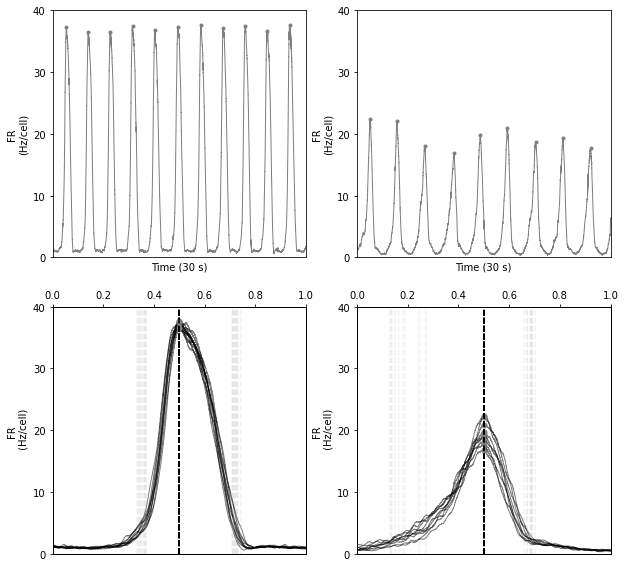

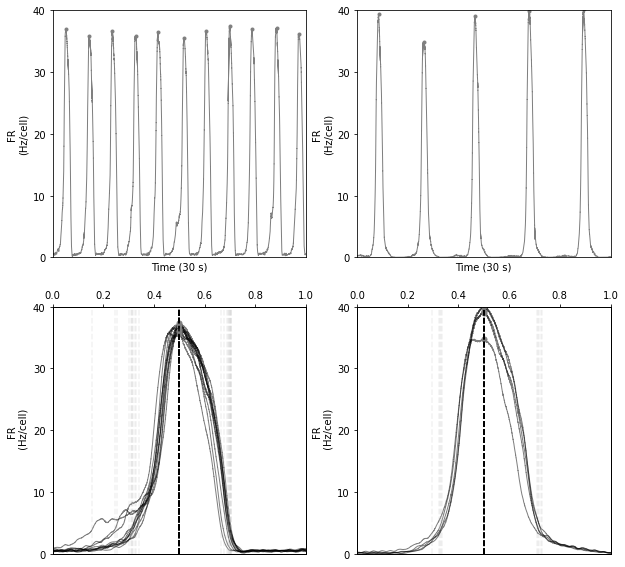

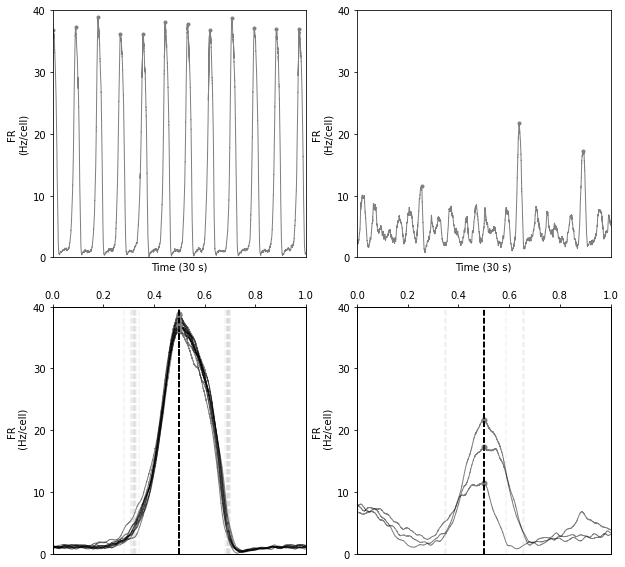

In [32]:
seed = 3

target = 'random'
pkl_path = f'data/gnap_mod_pkls'
with open(f'{path}/{pkl_path}/seed{seed}-str03_run_vars.pkl','rb') as fid:
    data = pickle.load(fid)
    random_gleak_rate = data['ratemonitor']
    
plot_pop_rate(random_gleak_rate, gleak_target='random')

# seed 1 network in targeted experiments != seed 1 network in random opioid assignment
# I'm choosing seed 1 here because we still get a few bursts when targeting high gLeak neurons.
# Otherwise, that subplot would be empty.
seed = 1 
targets = ['low', 'high']
for target in targets:
    pkl_path = f'data/damgo_to_{target}_gleak_pkls'
    with open(f'{path}/{pkl_path}/seed{seed}-gleak-03_damgo_to_{target}_gl_vars.pkl','rb') as fid:
        data = pickle.load(fid)
        targeted_gleak_rate = data['ratemonitor']

    plot_pop_rate(targeted_gleak_rate, gleak_target=target)

### Panel B

In [39]:
def plot_phase_diagrams(run_seed, gleak_target='random'): 
    f = plt.figure(figsize=(4.5,4))
    f.tight_layout()
    g = f.add_gridspec(2, 2)

    if gleak_target == 'random':
        with open(f'{path}/data/gnap_synblock_pkls/clouds_pkls/seed{run_seed}-control_clouds_vars.pkl','rb') as fid1:
            control_data = pickle.load(fid1)

        with open(f'{path}/data/gnap_synblock_pkls/clouds_pkls/seed{run_seed}-damgo_clouds_vars.pkl','rb') as fid2:
            damgo_data = pickle.load(fid2)
    
    else:
        with open(f'{path}/data/targeted_damgo_pkls/{gleak_target}_gleak_pkls/seed{run_seed}-control-{gleak_target}_gl_synblock_vars.pkl','rb') as fid1:
            control_data = pickle.load(fid1)

        with open(f'{path}/data/targeted_damgo_pkls/{gleak_target}_gleak_pkls/seed{run_seed}-damgo-{gleak_target}_gl_synblock_vars.pkl','rb') as fid2:
            damgo_data = pickle.load(fid2)

    with open(f'{path}/data/gnap_synblock_pkls/grid_pkls/control_grid_vars.pkl','rb') as fid1:
        grid_control_data = pickle.load(fid1)

    with open(f'{path}/data/gnap_synblock_pkls/grid_pkls/damgo_grid_vars.pkl','rb') as fid2:
        grid_damgo_data = pickle.load(fid2)

    for i in [0,1]: # to handle subplotting
        data_list = []
        data_list.append([control_data, grid_control_data, 'Control', gleak_target])
        if i == 0:
            data_list.append([damgo_data, grid_control_data, 'DAMGO', gleak_target])
        else:
            data_list.append([damgo_data, grid_damgo_data, 'DAMGO', gleak_target])
        j = 0
        for data in data_list:
            neurons = data[0]['neurongroup']
            ts = data[0]['spikemonitor']['t']
            spike_idx = data[0]['spikemonitor']['i']
            train = bup.create_train(ts,spike_idx)
            cell_int, cell_class = bup.find_bursters_pk_ISI(train,300,)

            #state = data[1]['statemonitor']
            grid_neurons = data[1]['neurongroup']
            ts = data[1]['spikemonitor']['t']
            spike_idx = data[1]['spikemonitor']['i']
            train = bup.create_train(ts,spike_idx)
            grid_cell_int, grid_cell_class = bup.find_bursters_pk_ISI(train,400,)

            ax = f.add_subplot(g[i,j])

    #       comment this loop to get rid of phase boundaries (in case we use Illustrator or Inkscape instead)
            for neuron in range(len(grid_cell_int)):
                if grid_cell_int[neuron] == 0:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:purple', marker='s', s=225, alpha=0.3)

                if grid_cell_int[neuron] == 1:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='gold', marker='s',s=225, alpha=0.3)

                if grid_cell_int[neuron] == 2:
                    #ax.plot(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', alpha=0.3)
                    ax.scatter(grid_neurons['g_l'][neuron]/nS, grid_neurons['g_nap'][neuron]/nS, c='tab:cyan', marker='s',s=225, alpha=0.3)

            if gleak_target == 'high':  
                if i == 0:
                    for neuron in range(len(cell_int)):
                        if neuron < 180:
                            if cell_int[neuron] == 0:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 1:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 2:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)
                else:
                    for neuron in range(len(cell_int)):
                        if neuron >= 180:
                            if cell_int[neuron] == 0:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 1:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 2:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)
            
            else:    
                if i == 0:
                    for neuron in range(len(cell_int)):
                        if (neuron >= 0 and neuron < 60) or neuron >= 180:
                            if cell_int[neuron] == 0:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 1:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)
                                #print(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS)

                            if cell_int[neuron] == 2:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)
                else:
                    for neuron in range(len(cell_int)):
                        if neuron >= 60 and neuron < 180:
                            if cell_int[neuron] == 0:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:purple', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 1:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='gold', edgecolor='k', alpha=0.7)

                            if cell_int[neuron] == 2:
                                ax.scatter(neurons['g_l'][neuron]/nS, neurons['g_nap'][neuron]/nS, c='tab:cyan', edgecolor='k', alpha=0.7)

            ax.set_title('')
            ax.set_xlim(0.3,1.4)
            ax.set_ylim(0.6,1.4)
            ax.set_xlabel(r'$g_{Leak} (nS)$')
            if j == 0:
                ax.set_ylabel(r'$g_{NaP} (nS)$')
            else:
                ax.set_ylabel('')
                ax.set_yticks([])

            j+=1
    
    f.suptitle(rf'{gleak_target} $G_L$', fontsize=12)

    #plt.savefig(f'fig5_phase_diagrams_{gleak_target}_gleak.pdf')

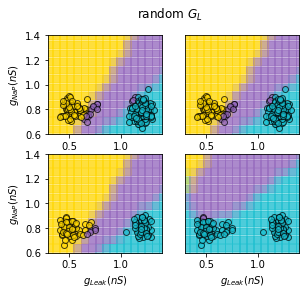

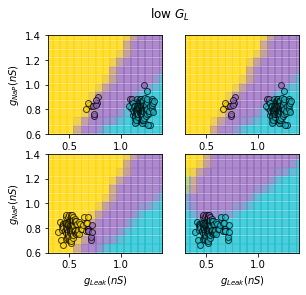

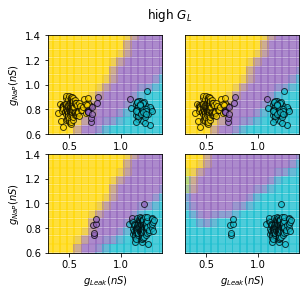

In [40]:
plot_phase_diagrams(3, 'random')
plot_phase_diagrams(1, 'low')
plot_phase_diagrams(1, 'high')

### Panel C

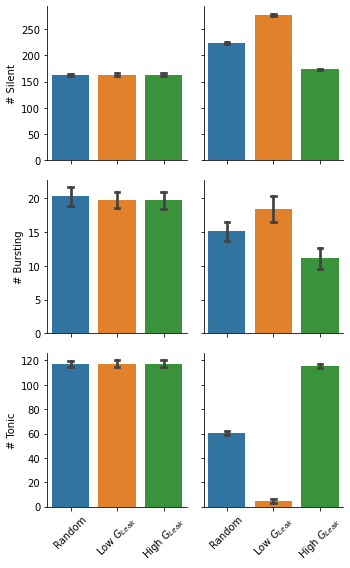

In [48]:
random_gl_tbq_counts = pd.read_csv(f'{path}/simulations/synblock_sim/ctrl_damgo_tbq_counts.csv')
low_gl_tbq_counts = pd.read_csv(f'{path}/simulations/targeted_damgo_sim/low_gl_ctrl_damgo_tbq_counts.csv')
high_gl_tbq_counts = pd.read_csv(f'{path}/simulations/targeted_damgo_sim/high_gl_ctrl_damgo_tbq_counts.csv')

random_gl_tbq_counts['damgo_target'] = r'Random'
random_gl_tbq_counts['run_seed'] = np.arange(1,41)
low_gl_tbq_counts['damgo_target'] = r'Low $G_{Leak}$'
low_gl_tbq_counts['run_seed'] = np.arange(1,41)
high_gl_tbq_counts['damgo_target'] = r'High $G_{Leak}$'
high_gl_tbq_counts['run_seed'] = np.arange(1,41)

df = pd.concat([random_gl_tbq_counts, high_gl_tbq_counts, low_gl_tbq_counts])
df = df.drop('Unnamed: 0', axis=1)

fig, axes = plt.subplots(3, 2, figsize=(5,8), sharex=True, sharey='row')
sns.barplot(ax=axes[0,0], x='damgo_target', y='ctrl_q_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])
sns.barplot(ax=axes[0,1], x='damgo_target', y='damgo_q_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])
sns.barplot(ax=axes[1,0], x='damgo_target', y='ctrl_b_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])
sns.barplot(ax=axes[1,1], x='damgo_target', y='damgo_b_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])
sns.barplot(ax=axes[2,0], x='damgo_target', y='ctrl_t_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])
sns.barplot(ax=axes[2,1], x='damgo_target', y='damgo_t_count', data=df, capsize=.1, order=['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'])

ylabs = ['# Silent', '# Bursting', '# Tonic']
for i in range(len(ylabs)):
    ylab = ylabs[i]
    for j in range(2):
        axes[i,j].set_xlabel('')
        axes[i,0].set_ylabel(ylab)
        axes[i,1].set_ylabel('')
        axes[i,j].spines['top'].set_visible(False)
        axes[i,j].spines['right'].set_visible(False)
        axes[2,j].set_xticklabels(['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$'], rotation=45)
plt.tight_layout()
plt.savefig('fig5_tbq_barplots.pdf')

### Panel D

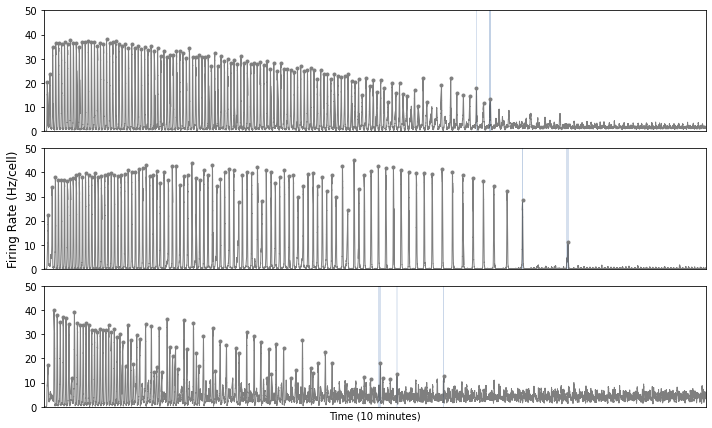

In [35]:
fig, ax = plt.subplots(3,1, figsize=(10,6), sharex=True, sharey=True)

seeds = [3,1,1]
files = [f'{path}/data/damgo_ramp_pkls/pcon_0.01/seed{seeds[0]}-damgo_ramp_pcon_0.01_vars.pkl',
         f'{path}/data/targeted_damgo_ramp_pkls/damgo_to_low_gl_ramp_pkls/seed{seeds[1]}-damgo-low_gl_ramp_vars.pkl',
         f'{path}/data/targeted_damgo_ramp_pkls/damgo_to_high_gl_ramp_pkls/seed{seeds[2]}-damgo-high_gl_ramp_vars.pkl']

i = 0
targets = ['Random', r'Low $G_{Leak}$', r'High $G_{Leak}$']
for file in files:
    with open(file, 'rb') as fid:
        data = pickle.load(fid)
    rate = data['ratemonitor']

    binsize = 25 * ms 
    smoothed_pop_rate = bup.smooth_saved_rate(rate, binsize)
    burst_stats = bup.pop_burst_stats(rate['t'], smoothed_pop_rate, height = 4, prominence = 10)

    # mark burst peaks
    ax[i].plot(rate['t'], smoothed_pop_rate, 'k', linewidth=1, alpha=0.5)
#         ax[i].set_xlabel('Time (s)')
#         ax[i].set_ylabel('FR\n(Hz/cell)')
    ax[i].set_xticks([])
    ax[i].set_xlim(0,600)
    ax[i].set_ylim(0,50)
    #ax[i].set_title(targets[i])
    for thresh in range(10,16):
        ax[i].axvspan(burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Onset Times'], burst_stats[burst_stats['Peaks'] >= thresh].iloc[-1]['Offset Times'], color='lightsteelblue', alpha=0.3, lw=0)
    ax[i].plot(burst_stats['Peak Times'], smoothed_pop_rate[burst_stats['Peak Samples']], ".", c='tab:gray')
    i+=1
    
ax[2].set_xlabel('Time (10 minutes)')
ax[1].set_ylabel('Firing Rate (Hz/cell)', fontsize=12)

plt.tight_layout()
plt.savefig('fig5_traces.pdf')

### Panel E

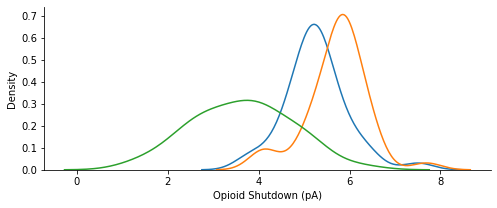

In [58]:
shutdown_vals = pd.read_csv(f'{path}/simulations/targeted_damgo_sim/thresholds.csv')
plt.figure(figsize=(8,3))
ax = plt.axes()
sns.kdeplot(shutdown_vals['random_gl_shutdown'], ax=ax)
sns.kdeplot(shutdown_vals['low_gl_shutdown'], ax=ax)
sns.kdeplot(shutdown_vals['high_gl_shutdown'], ax=ax)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Opioid Shutdown (pA)')
plt.savefig('fig5_distr.pdf')

In [60]:
shutdown_vals['random_gl_shutdown'].median()

5.250000000000002